## Analyze inter-cluster angles

In [1]:
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd
import concurrent.futures

def path_maker(template, **kwargs):
    template = str(template)
    for k, v in kwargs.items():
        template = template.replace("{"+ k +"}", str(v))
    return Path(template)

project_workdir = Path("/home/woodydrylab/DiskArray/b05b01002/project_umap_re/")
path_param_sets = project_workdir / "outputs/UMAP/param_table.csv"
path_seed_list = project_workdir / "outputs/UMAP/seeds.txt"
template_path_ica = project_workdir / "outputs/InterClusterAngle/{sample}/seed{seed}.csv"
template_path_cluster = project_workdir / "outputs/Seurat/{sample}/clusters.csv"
template_path_embeddings = project_workdir / "outputs/UMAP/{sample}/seed{seed}/param_set{param_set}.csv"
func_path_ica = lambda kwargs: path_maker(template_path_ica, **kwargs)
func_path_cluster = lambda kwargs: path_maker(template_path_cluster, **kwargs)
func_path_embeddings = lambda kwargs: path_maker(template_path_embeddings, **kwargs)

# sample
# samples = ["ath", "gar", "lch", "osa", "ptr", "tma", "zma"]
samples = ["zma"]

### Read data

#### 1. UMAP seeds

In [2]:
seeds = [l.strip() for l in open(path_seed_list, "r")]
len(seeds)

1000

#### 2. Parameter sets

In [3]:
param_sets = pd.read_csv(path_param_sets, index_col = 0)
param_sets.describe()

,n_neighbors,min_dist,n_epochs
count,360.000000,360.000000,360.000000
mean,78.000000,0.448333,375.000000
std,68.035711,0.357354,238.816721
min,10.000000,0.000000,100.000000
25%,30.000000,0.100000,175.000000
50%,50.000000,0.400000,350.000000
75%,100.000000,0.800000,550.000000
max,200.000000,0.990000,700.000000


#### 3. Cluster dfs

In [4]:
cluster_dfs = {
    sample: pd.read_csv(
        func_path_cluster(dict(sample=sample)),
        index_col=0,
        dtype=str,
        header=0,
        names=["cluster"] # overwrite existing headers
    ) for sample in samples
}
cluster_dfs[samples[0]]

,cluster
E1_e1_1_X262565,5
E1_e1_1_X335878,0
E1_e1_1_X364224,1
E1_e1_1_X247820,1
E1_e1_1_X193446,6
...,...
E1_e1_1_X8846,3
E1_e1_1_X397012,7
E1_e1_1_X756478,0
E1_e1_1_X853198,3


#### 4. Inter-cluster angle

In [5]:
ica_dfs = {}
for sample in samples:
    with concurrent.futures.ProcessPoolExecutor(max_workers=48) as executor:
        print(f"sample={sample}", end="")
        # submit jobs to pool
        futures = [
            executor.submit(pd.read_csv, func_path_ica(dict(sample=sample, seed=seed))) 
            for seed in seeds
        ]

        # store concurrent results to list
        df_list = []
        for fut in tqdm(
            concurrent.futures.as_completed(futures),
            total=len(futures)
        ):
            df_list.append(fut.result())

        # concat dataframe and map to dict for named access
        print("Concat...")
        ica_dfs[sample] = pd.concat(df_list, ignore_index=True)

        del df_list

sample=zma

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.19it/s]


Concat...


_**Extract only results of the first 8 clusters**_

In [6]:
for sample, ica_df in ica_dfs.items():
    mask1 = ica_df["vertex"] < 8
    mask2 = ica_df["cluster_a"] < 8
    mask3 = ica_df["cluster_b"] < 8
    ica_dfs[sample] = ica_df[mask1 & mask2 & mask3]
    print(sample, ica_dfs[sample].shape)

zma (60480000, 6)


### SD of inter-cluster angle cosine per parameter sets per cluster combinations

Calculate SD per param_set + cluster combo

In [7]:
ica_stds = {}
for sample, df in ica_dfs.items():
    ica_stds[sample] = (
        df
        .groupby(["param_set", "vertex", "cluster_a", "cluster_b"])
        .agg(cos_sd=("cos_similarity", "std"),)
    )

In [8]:
ica_avg_stds = pd.DataFrame()
for sample, df in ica_stds.items():
    foo = pd.merge(
        param_sets,
        df.groupby(["param_set"]).mean(),
        left_index=True,
        right_index=True
    )
    foo["sample"] = sample
    ica_avg_stds = pd.concat([ica_avg_stds, foo])
    
ica_avg_stds

,n_neighbors,min_dist,metric,n_epochs,cos_sd,sample
param_set,,,,,,
0,10,0.00,euclidean,100,0.286611,zma
1,10,0.00,euclidean,200,0.311849,zma
2,10,0.00,euclidean,500,0.335456,zma
3,10,0.00,euclidean,700,0.344840,zma
4,10,0.00,cosine,100,0.267821,zma
...,...,...,...,...,...,...
355,200,0.99,cosine,700,0.071214,zma
356,200,0.99,correlation,100,0.092495,zma
357,200,0.99,correlation,200,0.100981,zma


In [9]:
ica_avg_stds

,n_neighbors,min_dist,metric,n_epochs,cos_sd,sample
param_set,,,,,,
0,10,0.00,euclidean,100,0.286611,zma
1,10,0.00,euclidean,200,0.311849,zma
2,10,0.00,euclidean,500,0.335456,zma
3,10,0.00,euclidean,700,0.344840,zma
4,10,0.00,cosine,100,0.267821,zma
...,...,...,...,...,...,...
355,200,0.99,cosine,700,0.071214,zma
356,200,0.99,correlation,100,0.092495,zma
357,200,0.99,correlation,200,0.100981,zma


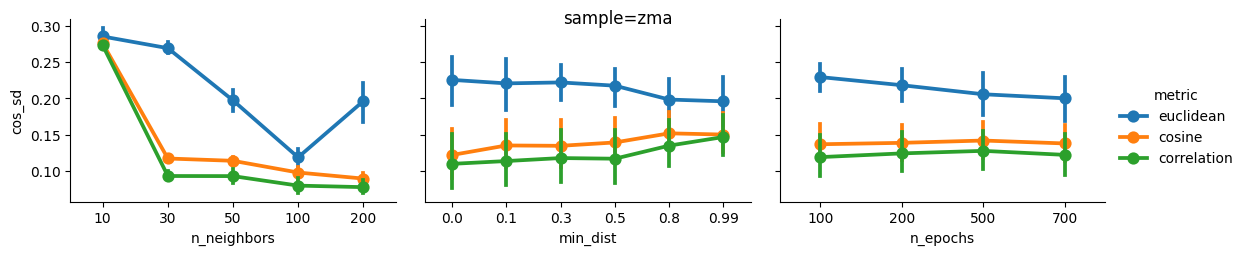

In [10]:
for sample in samples:
    g = sns.PairGrid(
        ica_avg_stds[ica_avg_stds["sample"] == sample],
        x_vars=["n_neighbors", "min_dist", "n_epochs"],
        y_vars=["cos_sd"],
        hue="metric",
        aspect=1.5
    )
    g.map(sns.pointplot) # , fliersize=1, gap=.2
    g.fig.suptitle(f"sample={sample}")
    g.add_legend()
    g.savefig(f"temp/one-sample/cos_sd~params_sample={sample}.svg")

In [11]:
# import pandas as pd
# import matplotlib.pyplot as plt

# def plot_coef(model):
#     # extract coefficients and confidence intervals
#     df = (
#         pd.concat(
#             [model.params, model.conf_int().rename(columns={0: "ci_low", 1: "ci_high"})],
#             axis=1
#         )
#         .reset_index()
#         .rename(columns={"index": "term", 0: "coef"})
#     )
    
#     # drop intercept
#     df = df[df["term"] != "Intercept"]
    
#     # clean term labels
#     df["label"] = (
#         df["term"]
#         .str.replace("C\\(", "", regex=True)
#         .str.replace("\\)", "", regex=True)
#         .str.replace(", Treatment\\(reference=[0-9.]*", "", regex=True)
#         .str.replace("\\[T\\.", " = ", regex=True)
#         .str.replace("\\]", "", regex=True)
#     )
    
#     # sort by effect size
#     df = df.sort_values("coef").reset_index(drop=True)
#     df["y"] = df.index
    
#     # plot coefficient effects with 95% CI
#     fig, ax = plt.subplots(figsize=(6, 8))
#     ax.errorbar(
#         df["coef"],
#         df["y"],
#         xerr=[
#             df["coef"] - df["ci_low"],
#             df["ci_high"] - df["coef"],
#         ],
#         fmt="o",
#         capsize=3
#     )
    
#     ax.axvline(0, linestyle="--", linewidth=1)
#     ax.set_yticks(df["y"])
#     ax.set_yticklabels(df["label"])
#     ax.set_xlabel("Estimated effect on cos_sd relative to reference level")
#     ax.set_title("UMAP hyperparameter effects on embedding instability")
    
#     plt.tight_layout()
#     return fig, ax

In [12]:
# import statsmodels.formula.api as smf

# mask1 = ica_avg_stds["metric"] == "cosine"
# model = smf.ols(
#     "cos_sd ~ "
#     "C(n_neighbors, Treatment(reference=10)) + "
#     "C(min_dist, Treatment(reference=0.0)) + "
#     "C(n_epochs, Treatment(reference=200)) + "
#     "C(sample)",
#     data=ica_avg_stds[mask1]
# ).fit()

# print(model.summary())
# fig, ax = plot_coef(model)
# plt.show()

### Show UMAP embeddings by varying parameters (produce grid of UMAPs)

UMAP plotting function

In [13]:
def plot_umap(path_embeddings, cluster_df, ax, highlights=None, bold=[], palette=None, **kwargs):
    # combinding embeddings with cluster_df
    embeddings = pd.read_csv(path_embeddings, index_col=0)
    embeddings_clusters = pd.merge(embeddings, cluster_df, left_index=True, right_index=True)

    # calculate cluster centroids
    cluster_centroids = embeddings_clusters.groupby(["cluster"]).median()
    cluster_centroids["cluster"] = cluster_centroids.index.tolist()

    # highlight all cluster if `hightlights` is not specified
    if highlights is None:
        highlights = embeddings_clusters["cluster"].unique().tolist()

    # assign non-highlight cluster as lightgray
    if palette is not None:
        palette = palette.copy()
        for clust in palette.keys():
            if clust not in highlights:
                palette[clust] = "lightgray"
        
    # plot cells
    sns.scatterplot(
        embeddings_clusters,
        x="UMAP1",
        y="UMAP2",
        hue="cluster",
        palette=palette,
        ax=ax,
        **kwargs
    )

    # plot cluster centorid and text lable
    for index, row in cluster_centroids.loc[highlights, :].iterrows():
        ax.text(
            x=row["UMAP1"],
            y=row["UMAP2"],
            s=row["cluster"],
            color="black",
            fontsize="large",
            fontweight="black" if row["cluster"] in bold else "normal",
            ha="center",
            va="center"
        )    
    # if highlights is not None:
    #     return palette, cluster_centroids
    #     fig = sns.scatterplot(
    #         cluster_centroids,
    #         x="UMAP1",
    #         y="UMAP2",
    #         c=[palette[c] for c in cluster_centroids["cluster"]],
    #         ax=ax,
    #         s=kwargs.get(s, 4) * 40
    #     )
    ax.relim()
    ax.autoscale_view()
    ax.set_axis_off()
    
    return

In [14]:
for sample in samples:
    for metric in ["euclidean", "cosine", "correlation"]:
        param_sets_subset = param_sets[
            (param_sets["metric"] == metric) &
            (param_sets["n_epochs"] == 200)
        ]
        row_levels = {value: idx for idx, value in enumerate(param_sets_subset["n_neighbors"].unique())}
        col_levels = {value: idx for idx, value in enumerate(param_sets_subset["min_dist"].unique())}
        
        g = sns.FacetGrid(
            param_sets_subset, 
            row="n_neighbors", 
            col="min_dist",
            sharex=False,
            sharey=False
        )
        for idx, row in param_sets_subset.iterrows():
            row_n = row_levels[row["n_neighbors"]]
            col_n = col_levels[row["min_dist"]]
            path_embeddings = func_path_embeddings(dict(sample=sample, seed=seeds[0], param_set=idx))
            ax = g.axes[row_n][col_n]
            plot_umap(path_embeddings, cluster_dfs[sample], ax, legend=False, s=4)
        
        g.fig.suptitle(f"sample={sample}, metrics={metric}, n_epochs=200", fontsize=10)
        g.fig.subplots_adjust(top=0.95)
        g.savefig(f"temp/one-sample/example_{sample}_{metric}.png")
        plt.close()

### Show extreme UMAP embeddings

Find seeds that give max and min cosine(angle) per cluster combinations per param sets

In [15]:
ica_mm_df = pd.DataFrame()
for sample, df in ica_dfs.items():
    # 
    g_df = df.groupby(["param_set", "vertex", "cluster_a", "cluster_b"])

    # 
    ica_max_min = (
        g_df.agg(
            max_cos=("cos_similarity", "max"),
            min_cos=("cos_similarity", "min"),
            cos_sd=("cos_similarity", "std")
        )
        .assign(
            max_cos_seed=df.loc[
                g_df["cos_similarity"].idxmax().values, "seed"
            ].values,
            min_cos_seed=df.loc[
                g_df["cos_similarity"].idxmin().values, "seed"
            ].values,
        )
    )
    ica_max_min["delta_max_min"] = ica_max_min.apply(lambda x: abs(x["max_cos"] - x["min_cos"]), axis=1)
    ica_max_min = pd.merge(ica_max_min, param_sets, left_index=True, right_index=True, how="left")
    ica_max_min["sample"] = sample
    ica_mm_df = pd.concat([ica_mm_df, ica_max_min])

Plot distribution of max(cos(angle)) - min(cos(angle))

In [16]:
for sample in samples:
    mask1 = ica_mm_df["sample"] == sample
    g = sns.FacetGrid(
        ica_mm_df[mask1],
        row="n_neighbors", 
        col="min_dist",
        hue="metric"
    )
    g.map_dataframe(sns.kdeplot, x="delta_max_min")
    g.add_legend()
    g.fig.suptitle(f"samples={sample}", fontsize=10)
    g.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.savefig(f"temp/one-sample/dist_max_diff_sample={sample}.svg")
    plt.close()

In [17]:
for sample in samples:
    mask1 = ica_mm_df["sample"] == sample
    g = sns.FacetGrid(
        ica_mm_df[mask1],
        row="n_neighbors", 
        col="min_dist",
        hue="metric"
    )
    g.map_dataframe(sns.kdeplot, x="cos_sd")
    g.add_legend()
    g.fig.suptitle(f"samples={sample}", fontsize=10)
    g.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.savefig(f"temp/one-sample/dist_cos_sd_sample={sample}.svg")
    plt.close()

Plot distribution of max(cos(angle)) - min(cos(angle)) per vertex

In [18]:
for sample in samples:
    mask1 = ica_mm_df["sample"] == sample
    g = sns.FacetGrid(
        ica_mm_df[mask1].reset_index(),
        row="n_neighbors", 
        col="min_dist",
        hue="vertex"
    )
    g.map_dataframe(sns.kdeplot, x="delta_max_min", linewidth=2)
    g.add_legend()
    g.fig.suptitle(f"samples={sample}", fontsize=10)
    g.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.savefig(f"temp/one-sample/dist_max_diff_by_vertex_sample={sample}.svg")
    plt.close()

In [19]:
for sample in samples:
    mask1 = ica_mm_df["sample"] == sample
    g = sns.FacetGrid(
        ica_mm_df[mask1].reset_index(),
        row="n_neighbors", 
        col="min_dist",
        hue="vertex"
    )
    g.map_dataframe(sns.kdeplot, x="cos_sd", linewidth=2)
    g.add_legend()
    g.fig.suptitle(f"samples={sample}", fontsize=10)
    g.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    g.savefig(f"temp/one-sample/dist_cos_sd_by_vertex_sample={sample}.svg")
    plt.close()

Plot UMAPs where max(cos(angle)), min(cos(angle)) are observed

In [20]:
for metric in param_sets["metric"].unique().tolist():
    for sample in samples:
        mask1 = ica_mm_df["sample"] == sample
        mask2 = ica_mm_df["metric"] == metric
        ica_max_min = ica_mm_df[mask1 & mask2]
    
        #
        g_max = sns.FacetGrid(ica_max_min, row="n_neighbors", col="min_dist", sharex=False, sharey=False)
        g_min = sns.FacetGrid(ica_max_min, row="n_neighbors", col="min_dist", sharex=False, sharey=False)
        
        #
        row_levels = {value: idx for idx, value in enumerate(ica_max_min["n_neighbors"].unique())}
        col_levels = {value: idx for idx, value in enumerate(ica_max_min["min_dist"].unique())}
        
        #
        labels = cluster_dfs[sample]["cluster"].unique()
        colors = plt.get_cmap("tab10").colors
        palette = {k: colors[i % len(colors)] for i, k in enumerate(labels)}
        
        #
        for nn in ica_max_min["n_neighbors"].unique():
            for md in ica_max_min["min_dist"].unique():
                # 
                row_n = row_levels[nn]
                col_n = col_levels[md]
        
                # 
                mask1 = ica_max_min["n_neighbors"] == nn
                mask2 = ica_max_min["min_dist"] == md
                mask3 = ica_max_min["n_epochs"] == 200
                ica_diff_subset = ica_max_min.loc[mask1 & mask2 & mask3].reset_index()
                ica_max_diff = ica_diff_subset.loc[ica_diff_subset["delta_max_min"].idxmax(), :]
                
                #
                path_embeddings_max = func_path_embeddings(dict(
                    sample=sample,
                    seed=ica_max_diff["max_cos_seed"],
                    param_set=ica_max_diff["param_set"]
                ))
                plot_umap(
                    path_embeddings_max,
                    cluster_dfs[sample], 
                    ax=g_max.axes[row_n][col_n], 
                    highlights=ica_max_diff[["vertex", "cluster_a", "cluster_b"]].values.astype(str).tolist(),
                    bold=ica_max_diff[["vertex"]].values.astype(str).tolist(),
                    palette=palette.copy(),
                    legend=False, 
                    s=5
                )
    
                # 
                path_embeddings_min = func_path_embeddings(dict(
                    sample=sample,
                    seed=ica_max_diff["min_cos_seed"],
                    param_set=ica_max_diff["param_set"]
                ))
                plot_umap(
                    path_embeddings_min, 
                    cluster_dfs[sample],
                    ax=g_min.axes[row_n][col_n], 
                    highlights=ica_max_diff[["vertex", "cluster_a", "cluster_b"]].values.astype(str).tolist(),
                    bold=ica_max_diff[["vertex"]].values.astype(str).tolist(),
                    palette=palette,
                    legend=False, 
                    s=5
                )

        # save and close
        g_max.savefig(f"temp/one-sample/max_umap_metric={metric}_sample={sample}.png")
        g_min.savefig(f"temp/one-sample/min_umap_metric={metric}_sample={sample}.png")
        plt.close("all")

### Test procrustes alignment and:
1. Plot aligned UMAPs
2. Plot stacked UMAPs
3. Plot median UMAP

In [21]:
from scipy.linalg import orthogonal_procrustes
from itertools import combinations
import pandas as pd
import numpy as np
import argparse

def align_to_reference(Y, X):
    """
    Align embedding Y to reference X using orthogonal Procrustes.
    Returns aligned Y and RMSD.
    """
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)

    R, _ = orthogonal_procrustes(Yc, Xc)
    Y_aligned = Yc @ R

    rmsd = np.sqrt(((Xc - Y_aligned) ** 2).sum(axis=1).mean())
    return Y_aligned, rmsd

def find_reference(embeddings):
    """
    embeddings: list of (n_samples, n_dims) numpy arrays
    Returns index of reference embedding and per-embedding mean RMSD.
    """
    n = len(embeddings)
    mean_rmsd = np.zeros(n)

    for i in range(n):
        Xi = embeddings[i]
        rmsds = []

        for j in range(n):
            if i == j:
                continue
            _, rmsd = align_to_reference(embeddings[j], Xi)
            rmsds.append(rmsd)

        mean_rmsd[i] = np.mean(rmsds)

    ref_idx = np.argmin(mean_rmsd)
    return ref_idx, mean_rmsd

For each metric, get the param combination that minimize average SD(cos)

In [24]:
best_combinations = []
for metric in ica_avg_stds["metric"].unique():
    mask1 = ica_avg_stds["metric"] == metric
    mask2 = ica_avg_stds["min_dist"] == 0.3
    idx_min_metric = ica_avg_stds[mask1 & mask2]["cos_sd"].idxmin()
    foo = ica_avg_stds.loc[idx_min_metric, ["metric", "n_neighbors", "min_dist", "n_epochs"]].to_dict()
    best_combinations.append(foo)
print(*best_combinations, sep="\n")

{'metric': 'euclidean', 'n_neighbors': 100, 'min_dist': 0.3, 'n_epochs': 700}
{'metric': 'cosine', 'n_neighbors': 200, 'min_dist': 0.3, 'n_epochs': 500}
{'metric': 'correlation', 'n_neighbors': 200, 'min_dist': 0.3, 'n_epochs': 100}


In [25]:
sample = samples[0]
n_seeds = 25

for param_comb in best_combinations:
    # get param set idx
    conds = []
    for p, v in param_comb.items():
        cond_p = param_sets[p] == v
        if len(conds) == 0:
            conds = cond_p
        else:
            conds = conds & cond_p
            
    param_set_n = param_sets[conds].index.tolist()[0]

    
    # read embeddings
    embeddings_df = [
        pd.read_csv(
            func_path_embeddings(dict(sample=sample, seed=seed, param_set=param_set_n)),
            index_col=0
        ) for seed in seeds[:n_seeds]
    ]
    embeddings = [df.values for df in embeddings_df]

    # calculate RMSD after pairwise alignment
    ref_idx, mean_rmsd = find_reference(embeddings)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.histplot(mean_rmsd, bins=10, ax=ax)
    fig.suptitle(" | ".join([f"sample = {sample}"] + [f"{k} = {v}" for k, v in param_comb.items()]))
    fig.savefig(f"temp/one-sample/rmsd_metric={param_comb['metric']}_sample={sample}.png")
    plt.close()
    print("Chosen reference seed:", seeds[ref_idx])


    # align embeddings to reference
    X_ref = embeddings[ref_idx]
    aligned_embeddings = []
    for Y in embeddings:
        Y_aligned, _ = align_to_reference(Y, X_ref)
        aligned_embeddings.append(Y_aligned)
    
    # put back cluster and seed columns
    aligned_dfs = []
    for df, Y_aligned, seed in zip(embeddings_df, aligned_embeddings, seeds):
        aligned_df = df.copy()
        aligned_df[["UMAP1", "UMAP2"]] = Y_aligned
        aligned_df = pd.merge(aligned_df, cluster_dfs[sample], left_index=True, right_index=True)
        aligned_df["seed"] = seed
        aligned_dfs.append(aligned_df)
    
    # 1. plot aligned embeddings
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    order_by_mean_rmsd = sorted(range(len(mean_rmsd)), key=mean_rmsd.__getitem__)
    for idx, ax in zip(order_by_mean_rmsd, axes.flatten()):
        sns.scatterplot(
            data=aligned_dfs[idx],
            x="UMAP1",
            y="UMAP2",
            hue="cluster",
            ax=ax,
            legend=False,
            s=1
        )
        ax.set_title(f"seed = {seeds[idx]}")
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.suptitle(" | ".join([f"sample = {sample}"] + [f"{k} = {v}" for k, v in param_comb.items()]))
    fig.savefig(f"temp/one-sample/procrustes_aligned_metric={param_comb['metric']}_sample={sample}.png")
    plt.close()


    # 2. plot median embeddings
    concated_df = pd.DataFrame()
    for idx in range(len(aligned_dfs)):
        concated_df = pd.concat([concated_df, aligned_dfs[idx]])
    
    median_embedding = (
        concated_df
        .groupby(concated_df.index)
        .agg(
            UMAP1_median=("UMAP1", "median"),
            UMAP2_median=("UMAP2", "median"),
            cluster=("cluster", "first"),
            seed=("seed", "first")
        )
    )
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.scatterplot(
        data=median_embedding,
        x="UMAP1_median",
        y="UMAP2_median",
        hue="cluster",
        legend=False,
        ax=ax,
        s=4
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.suptitle(" | ".join([f"sample = {sample}"] + [f"{k} = {v}" for k, v in param_comb.items()]))
    fig.savefig(f"temp/one-sample/procrustes_median_metric={param_comb['metric']}_sample={sample}.png")
    plt.close()


    # 3. plot stacked embeddings
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.scatterplot(
        data=concated_df,
        x="UMAP1",
        y="UMAP2",
        hue="cluster",
        legend=False,
        ax=ax,
        alpha=.05,
        s=2
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.suptitle(" | ".join([f"sample = {sample}"] + [f"{k} = {v}" for k, v in param_comb.items()]))
    fig.savefig(f"temp/one-sample/procrustes_stacked_metric={param_comb['metric']}_sample={sample}.png")
    plt.close()

Chosen reference seed: 23434
Chosen reference seed: 22280
Chosen reference seed: 22280
